# Project 5 - Vehicle Detection and Tracking

## Vehicle Detection Project

### The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.

## Initial Imports

In [60]:
#Initial Imports
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from scipy.ndimage.measurements import label
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Functions / All the things

### A list of all functions used throughout

In [81]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# For Use:
# Add bounding boxes in this format, these are just example coordinates.
# bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
#           ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

# result = draw_boxes(image, bboxes)
# plt.imshow(result)

##################

# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list
#for use
# bboxes = find_matches(image, templist)
# result = draw_boxes(image, bboxes)
# plt.imshow(result)
##############################################

# Define a function to compute color histogram features  
def color_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Define a function to compute hsv histogram features  
def hsv_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the hsv channels separately
    hhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    shist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    vhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hhist[0], shist[0], vhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hhist, shist, vhist, bin_centers, hist_features

# Define a function to compute yuv histogram features  
def yuv_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the hsv channels separately
    yhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    uhist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    vhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = yhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((yhist[0], uhist[0], vhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return yhist, uhist, vhist, bin_centers, hist_features

# rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# # Plot a figure with all three bar charts
# if rh is not None:
#     fig = plt.figure(figsize=(12,3))
#     plt.subplot(131)
#     plt.bar(bincen, rh[0])
#     plt.xlim(0, 256)
#     plt.title('R Histogram')
#     plt.subplot(132)
#     plt.bar(bincen, gh[0])
#     plt.xlim(0, 256)
#     plt.title('G Histogram')
#     plt.subplot(133)
#     plt.bar(bincen, bh[0])
#     plt.xlim(0, 256)
#     plt.title('B Histogram')
#     fig.tight_layout()
# else:
#     print('Your function is returning None for at least one variable...')
    
#############################

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

#For Use:
# # Read a color image
# img = cv2.imread("000275.png")

# # Select a small fraction of pixels to plot by subsampling it
# scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
# img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# # Convert subsampled image to desired color space(s)
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
# img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
# img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# # Plot and show
# plot3d(img_small_RGB, img_small_rgb)
# plt.show()

# plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
# plt.show()

#############################################

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(64, 64)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

#For Use:
#feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))
# Plot features
# plt.plot(feature_vec)
# plt.title('Spatially Binned Features')

###############################################

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

#For Use:
# print('Your function returned a count of', 
#       data_info["n_cars"], ' cars and', 
#       data_info["n_notcars"], ' non-cars')
# print('of size: ',data_info["image_shape"], ' and data type:', 
#       data_info["data_type"])
# # Just for fun choose random car / not-car indices and plot example images   
# car_ind = np.random.randint(0, len(cars))
# notcar_ind = np.random.randint(0, len(notcars))
# Read in car / not-car images
# car_image = mpimg.imread(cars[car_ind])
# notcar_image = mpimg.imread(notcars[notcar_ind])


# # Plot the examples
# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(car_image)
# plt.title('Example Car Image')
# plt.subplot(122)
# plt.imshow(notcar_image)
# plt.title('Example Not-car Image')
#########################

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# #For Use:
# # Generate a random index to look at a car image
# ind = np.random.randint(0, len(cars))
# # Read in the image
# image = mpimg.imread(cars[ind])
# gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# # Define HOG parameters
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# # Call our function with vis=True to see an image output
# features, hog_image = get_hog_features(gray, orient, 
#                         pix_per_cell, cell_per_block, 
#                         vis=True, feature_vec=False)


# # Plot the examples
# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(image, cmap='gray')
# plt.title('Example Car Image')
# plt.subplot(122)
# plt.imshow(hog_image, cmap='gray')
# plt.title('HOG Visualization')
#################################################

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(64, 64),
                        hist_bins=64, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file) #mpimg.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#For Use:
# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)
        
# car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))

# if len(car_features) > 0:
#     # Create an array stack of feature vectors
#     X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
#     # Fit a per-column scaler
#     X_scaler = StandardScaler().fit(X)
#     # Apply the scaler to X
#     scaled_X = X_scaler.transform(X)
#     car_ind = np.random.randint(0, len(cars))
#     # Plot an example of raw and scaled features
#     fig = plt.figure(figsize=(12,4))
#     plt.subplot(131)
#     plt.imshow(mpimg.imread(cars[car_ind]))
#     plt.title('Original Image')
#     plt.subplot(132)
#     plt.plot(X[car_ind])
#     plt.title('Raw Features')
#     plt.subplot(133)
#     plt.plot(scaled_X[car_ind])
#     plt.title('Normalized Features')
#     fig.tight_layout()
# else: 
#     print('Your function only returns empty feature vectors...')
##########################################################

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# a function to calculate slide windows similarly to slide_window but proportionally adjusting the window size
# to the y values of the image. An xy window closer to the beginning of the y(midpoint of the image) will be smaller
# than the windows near the bottom. This will capture cars in windows far away and close to the camera much better than
# searching in a constant window size
def my_slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.25, 0.25)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
#     # Compute the number of pixels per step in x/y
#     nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
#     ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
#     # Compute the number of windows in x/y
#     nx_windows = np.int(xspan/nx_pix_per_step) - 1
#     ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(int(y_start_stop[0]),int(y_start_stop[1])):
        for xs in range(x_start_stop[0],int(x_start_stop[1])):
            ratio = 1/(20-10*int(ys/int(y_start_stop[1])))
            window_size = int(ratio * ys)
            xy_window = (window_size, window_size)
            # Compute the number of pixels per step in x/y
            nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
            ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
            # Compute the number of windows in x/y
            nx_windows = np.int(xspan/nx_pix_per_step) - 1
            ny_windows = np.int(yspan/ny_pix_per_step) - 1
            for y_windows in range(ny_windows):
                for x_windows in range(nx_windows):
                    # Calculate window position
                    startx = x_windows*nx_pix_per_step + x_start_stop[0]
                    endx = startx + xy_window[0]
                    starty = y_windows*ny_pix_per_step + y_start_stop[0]
                    endy = starty + xy_window[1]
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    print(len(window_list))
    print(window_list[0])
    return window_list

#####################################################

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(64,64),
                        hist_bins=64, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

#####################################

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clfs, scaler, color_space='RGB', 
                    spatial_size=(64, 64), hist_bins=64, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier (now uses multiple classifiers)
        predictions = 0 #We want all classifiers to be positive in agreement
        for clf in clfs:
            prediction = clf.predict(test_features)/len(clfs)
            predictions+= prediction
        #7) If positive (prediction == 1) then save the window (if all predictions greater than a threshold)
        if predictions >= .5: #half of classifiers think car...
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#######################################

def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 3 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    #make a copy of the image
    draw_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((int(np.min(nonzerox)), int(np.min(nonzeroy))), (int(np.max(nonzerox)), int(np.max(nonzeroy))))
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 3)
    # Return the image
    return draw_img

######################




## Implementation

First, I'll get the iamges of the cars and explore the data

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


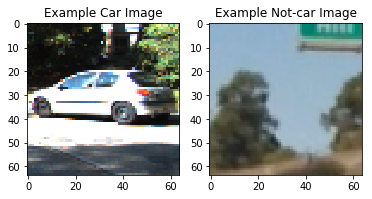

In [3]:
#read the images for cars/not cars
car_images = glob.glob('vehicles/*/*.png')
noncar_images = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []
for image in noncar_images:
    notcars.append(image)
for image in car_images:
    cars.append(image)

data_info = data_look(car_images,noncar_images)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
#Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Explore Color Spaces of the Images

Now, I'll look at the various color spaces of the image to gain insight as to what might be a good spectral signature for the car.

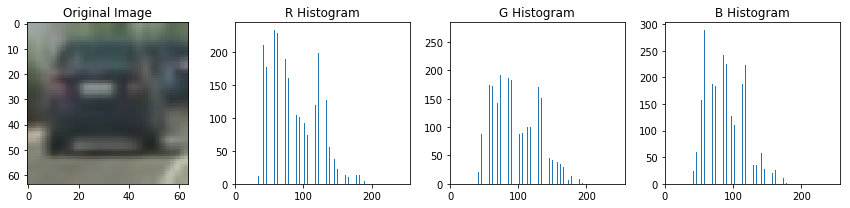

In [4]:
car_image = cv2.imread(cars[0]) #Be sure to use cv2.imread and scale to 0 -255 NOT mpimg.imread(cars[0])
#scale by changing color spaces
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(car_image)
    plt.title('Original Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

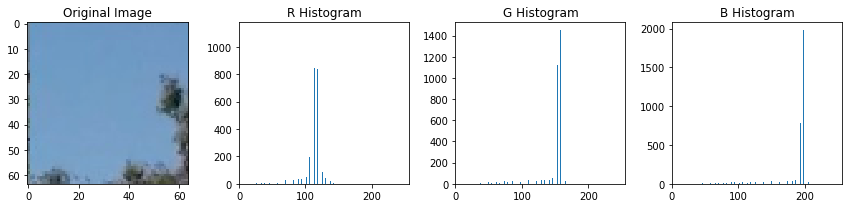

In [5]:
noncar_image = cv2.imread(notcars[0]) #Be sure to use cv2.imread and scale to 0 -255 NOT mpimg.imread(cars[0])
#scale by changing color spaces
noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(noncar_image, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(noncar_image)
    plt.title('Original Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

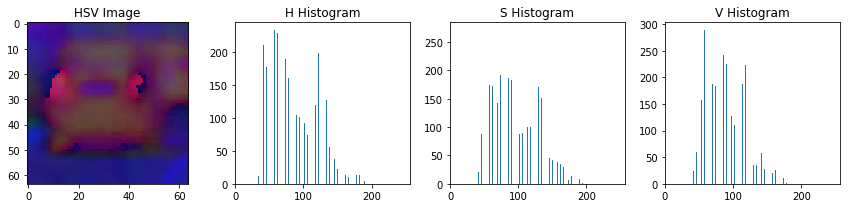

In [6]:
img_copy = np.copy(car_image)
car_image_hsv = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HSV)
rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(car_image_hsv)
    plt.title('HSV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('H Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

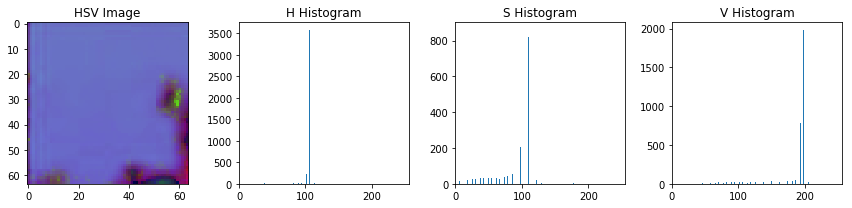

In [7]:
img_copy2 = np.copy(noncar_image)
noncar_image_hsv = cv2.cvtColor(img_copy2, cv2.COLOR_RGB2HSV)
rh, gh, bh, bincen, feature_vec = color_hist(noncar_image_hsv, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(noncar_image_hsv)
    plt.title('HSV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('H Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

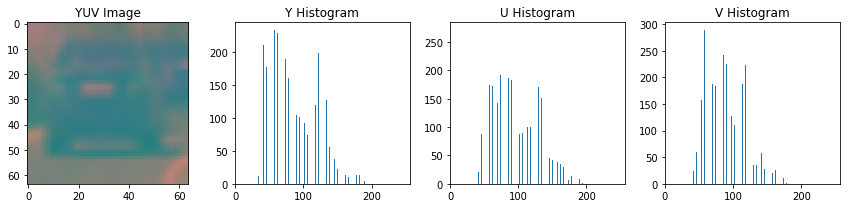

In [8]:
img_copy3 = np.copy(car_image)
car_image_YUV = cv2.cvtColor(img_copy3, cv2.COLOR_RGB2YUV)
rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(car_image_YUV)
    plt.title('YUV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('U Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

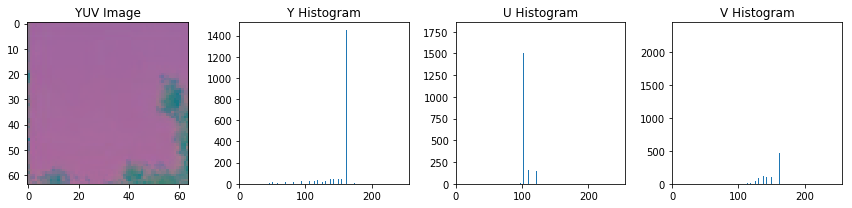

In [9]:
img_copy4 = np.copy(noncar_image)
noncar_image_yuv = cv2.cvtColor(img_copy2, cv2.COLOR_RGB2YUV)
rh, gh, bh, bincen, feature_vec = color_hist(noncar_image_yuv, nbins=64, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(noncar_image_yuv)
    plt.title('YUV Image')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('U Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

Clearly, there are very distinct differences in cars' color spaces versus non-cars that can uniquely identify a car.

### Ultimately, the color space as I was getting best results with was the YUV color space. Selecting this color space for the classifier gave me >99% accuracy on three classifiers!

## Look at Spatial Bins

Now I'll explore the spatial distribution of color in the car image versus the noncar image to include in the spectral signature.

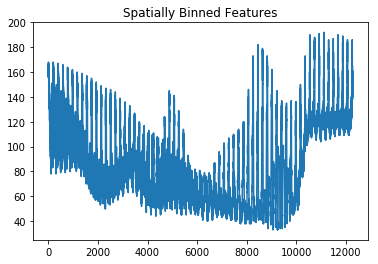

In [10]:
feature_vec = bin_spatial(car_image, color_space='RGB', size=(64, 64))
#Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

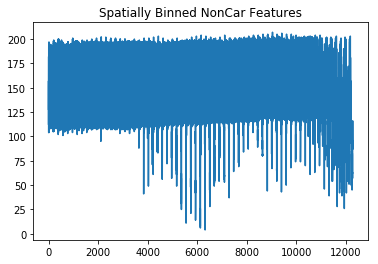

In [11]:
feature_vec = bin_spatial(noncar_image, color_space='RGB', size=(64, 64))
#Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned NonCar Features')

Once again, the spatial distribution of color gives a very distinct signature for cars as well.

## Look at HOG Features

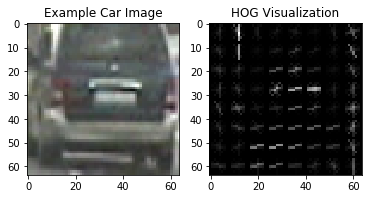

In [12]:
# # Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
example_car = cv2.imread(car_images[ind])
example_car = cv2.cvtColor(example_car, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(example_car, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(example_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

Here we can see the HOG gives a very unique structure for the car versus noncar and is easily identifiable.

I settled on the final HOG parameters empirically. I played with each one until to see which got better results in the classifiers and ended up with the orientation of 9, 8 pixels per cell, and 2 cells per block.

## Train Classifiers and Test on an Image

Now that we have a good combination of factors to create a good spectral signature for a car let's train some classifiers and test on image.

I use several classifiers including some that were not detailed in the Udacity lecture to see different results.  I then use a combination of these for the classification when I test the image. For each classifier that I used I sum each one's result and then get the average of that sum. If the average is above .5 then I accept that as a car image.

My reasoning to this is that some classifiers might have false-positives where others do not and I was able to get rid of a lot of false-positives and better identify cars this way.

On the downside, having more classifiers decreases performance especially with the K-nearest neighbor and Random Forest classifiers. For this reason I left the K-nearest neighbor classifier out while keeping the Random Forest because I achieved greater than 99% accuracy with the Random Forest.

(720, 1280, 3)


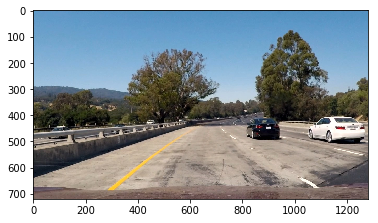

In [13]:
### Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
example_img = cv2.imread('test1.jpg')
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
print(example_img.shape)
plt.imshow(example_img)

In [14]:
#extract the features for cars/ noncars
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [15]:
#Define the features and labels vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [16]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


In [17]:
#Fit the classifier and make a prediction
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 19536
27.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9941


In [43]:
# #Use a decision tree classifier - this takes quite a while to train...
# #Fit the classifier and make a prediction
# # Use a decision tree 
# tree_clf = tree.DecisionTreeClassifier()
# tree_clf = tree_clf.fit(X_train, y_train)
# # Check the training time for the Decision tree
# t=time.time()
# tree_clf.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train Decision Tree...')
# # Check the score of the tree
# print('Test Accuracy of Decision Tree = ', round(tree_clf.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()

# Random Forests
random_forest = RandomForestClassifier(n_estimators=128,criterion="entropy")
t=time.time()
random_forest.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train Random Forest...')
print('Test Accuracy of Random Forest = ', round(random_forest.score(X_test, y_test), 4))
t=time.time()

104.1 Seconds to train Random Forest...
Test Accuracy of Random Forest =  0.991


In [29]:
# Naive Bayes

gaussianNB = GaussianNB()
t=time.time()
gaussianNB.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train Gaussian Naive Bayes...')
print('Test Accuracy of GaussNB = ', round(gaussianNB.score(X_test, y_test), 4))
t=time.time()

5.63 Seconds to train Gaussian Naive Bayes...
Test Accuracy of GaussNB =  0.9217


In [36]:
#K neighbors classifier
knn = KNeighborsClassifier(n_neighbors = 9)
t=time.time()
knn.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train KNN...')
print('Test Accuracy of KNN = ', round(knn.score(X_test, y_test), 4))
t=time.time()

23.37 Seconds to train KNN...
Test Accuracy of KNN =  0.9347


In [64]:
#Multi-layer perceptron
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(12,8), random_state=1)
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train MLP...')
print('Test Accuracy of MLP = ', round(mlp.score(X_test, y_test), 4))
t=time.time()

23.43 Seconds to train MLP...
Test Accuracy of MLP =  0.9961


Number of windows: 15


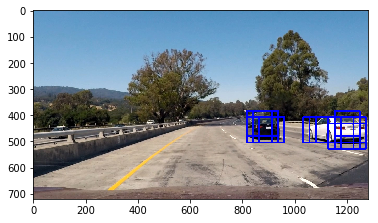

In [103]:
image = mpimg.imread('test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

#define 5 spaces to grab windows of different size
windows = []
# # 1) from .4 - .55
y_start_stop = [int(image.shape[0]*.3), int(image.shape[0]*.45)] # Min and max in y to search in slide_window()
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(32,32), xy_overlap=(0.75, 0.75))
if len(windows1) > 0:
   windows += windows1
# 2) from .55 to .70 of image
y_start_stop = [int(image.shape[0]*.35), int(image.shape[0]*.6)] # Min and max in y to search in slide_window()
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64,64), xy_overlap=(0.75, 0.75))
if len(windows2) > 0:
   windows += windows2
# 3) from .70 to .85
y_start_stop = [int(image.shape[0]*.5), int(image.shape[0]*.75)] # Min and max in y to search in slide_window()
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96,96), xy_overlap=(0.75, 0.75))
if len(windows3) > 0:
    windows = windows + windows3
# 4) from .75 to .9 of image
y_start_stop = [int(image.shape[0]*.65), int(image.shape[0]*.9)] # Min and max in y to search in slide_window()
windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128,128), xy_overlap=(0.75, 0.75))
if len(windows4) > 0:
   windows += windows4

# 5) from .85 to .9 of image
y_start_stop = [int(image.shape[0]*.65), int(image.shape[0]*.9)] # Min and max in y to search in slide_window()
windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(160,160), xy_overlap=(0.75, 0.75))
if len(windows5) > 0:
   windows += windows5

#one last one for a very large window area
y_start_stop = [int(image.shape[0]*.5), int(image.shape[0]*.9)] # Min and max in y to search in slide_window()
windows6 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(220,220), xy_overlap=(0.25, 0.25))
if len(windows6) > 0:
   windows += windows6

# y_start_stop = (int(image.shape[0]*.5),int(image.shape[0]))
# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(96,96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, [svc,mlp,gaussianNB], X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
print('Number of windows: %d' % len(hot_windows))
plt.imshow(window_img)

## Create a Heatmap and Label the Cars

(720, 1280)
2 cars found


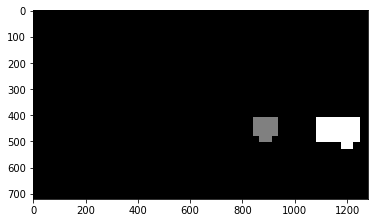

In [104]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
print(heat.shape)
#1 frame
heat = add_heat(heat,hot_windows)
# 2 frame
# heat = add_heat(heat, hot_windows)
# # 3 frame
# heat = add_heat(heat, hot_windows)
# #4 frame
# heat = add_heat(heat, hot_windows)
# #5 frame
# heat = add_heat(heat, hot_windows)
heat = apply_threshold(heat, 2)
labels = label(heat)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

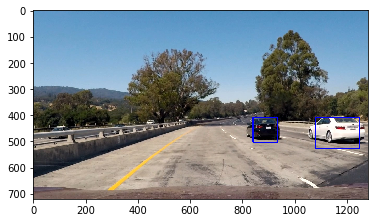

In [105]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

## Test on a test video first

The technique for the sliding windows that I employed was to go over different parts of the image with different size squares to capture cars further away and closer up. The window sizes increase as they go from the midpoint of the image to the bottom with plenty of overlap to avoid missing in cars. The smaller windows near the midpoint can capture cars far away and the larger ones near the bottom of the image will capture the cars closer to the camera.

(540, 960)


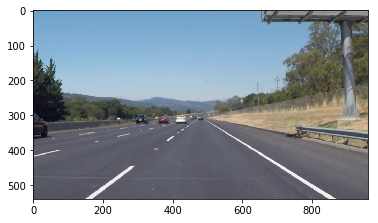

In [88]:
#define a new heatmap for the video
ex_image = cv2.imread('ex_vid_img.jpg')
heat = np.zeros_like(ex_image[:,:,0]).astype(np.float)
total = 0
print(heat.shape)
plt.imshow(ex_image)

In [170]:

def processImage(image):
    #print(img.shape)
    global heat
    #print(heat2.shape)
    global total
    global svc
    global random_forest
    global mlp
    global gaussianNB
    global knn
    global X_scaler
    ### Tweak these parameters and see how the results change.
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (64, 64) # Spatial binning dimensions
    hist_bins = 64    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = (int(image.shape[0]*.4), int(image.shape[0]*.9))
   
#     windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(32,32), xy_overlap=(0.75, 0.75))

    #define spaces to grab windows of different size
    windows = []
    # 1) from .4 - .55
#     y_start_stop = [int(image.shape[0]*.3), int(image.shape[0]*.45)] # Min and max in y to search in slide_window()
#     windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(16,16), xy_overlap=(0.5, 0.5))
#     if len(windows1) > 0:
#        windows += windows1
    
    # 1a) add another smaller windows to capture far away cars
#     y_start_stop = [int(image.shape[0]*.3), int(image.shape[0]*.45)] # Min and max in y to search in slide_window()
#     windows1a = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(8,8), xy_overlap=(0.75, 0.75))
#     if len(windows1a) > 0:
#        windows += windows1a
    # 2) from .55 to .70 of image
#     y_start_stop = [int(image.shape[0]*.5), int(image.shape[0]*.95)] # Min and max in y to search in slide_window()
#     windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(32,32), xy_overlap=(0.5, 0.5))
#     if len(windows2) > 0:
#        windows += windows2
#     # 3) from .70 to .85 THIS CAPTURES SMALLER WINDOWS OF THE CARS
    y_start_stop = [int(image.shape[0]*.5), int(image.shape[0]*.95)] # Min and max in y to search in slide_window()
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64,64), xy_overlap=(0.6, 0.6))
    if len(windows3) > 0:
        windows += windows3
    
    #3a   THIS CAPTURES THE MAJORITY OF THE WINDOWS
    y_start_stop = [int(image.shape[0]*.5), int(image.shape[0]*.95)] # Min and max in y to search in slide_window()
    windows3a = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96,96), xy_overlap=(0.6, 0.6))
    if len(windows3a) > 0:
        windows += windows3a
    # 4) from .65 to .9 of image THIS CAPTURES NOTHING
#     y_start_stop = [int(image.shape[0]*.65), int(image.shape[0]*.95)] # Min and max in y to search in slide_window()
#     windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(128,128), xy_overlap=(0.75, 0.75))
#     if len(windows4) > 0:
#        windows += windows4

    # 5) from .75 to .9 of image THIS CAPTURES NEARLY NOTHING
#     y_start_stop = [int(image.shape[0]*.65), int(image.shape[0]*.95)] # Min and max in y to search in slide_window()
#     windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(160,160), xy_overlap=(0.5, 0.5))
#     if len(windows5) > 0:
#        windows += windows5
    
    #one last one for a very large window area THIS CAPTURES A FEW UP CLOSE BUT NOT MUCH
#     y_start_stop = [int(image.shape[0]*.5), int(image.shape[0]*.9)] # Min and max in y to search in slide_window()
#     windows6 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(220,220), xy_overlap=(0.5, 0.5))
#     if len(windows6) > 0:
#        windows += windows6

    hot_windows = search_windows(image, windows, [svc,mlp,gaussianNB], X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    #window_img = draw_boxes(image, hot_windows, color=(125, 125, 255), thick=2)
    heat_new = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat_new,hot_windows) #add more heat to the original heatmap
    apply_threshold(heat, 0)
    labels = label(heat)
    #print(labels[1], 'cars found')
    # Draw bounding boxes on a copy of the image
    result = draw_labeled_bboxes(image, labels)
    total+=1
    return result

In [168]:
#test on video

video_output = 'test_project_video_output.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

output_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_project_video_output.mp4
[MoviePy] Writing video test_project_video_output.mp4






  0%|          | 0/222 [00:00<?, ?it/s]



  0%|          | 1/222 [00:02<09:35,  2.61s/it]



  1%|          | 2/222 [00:05<09:34,  2.61s/it]



  1%|▏         | 3/222 [00:08<10:22,  2.84s/it]



  2%|▏         | 4/222 [00:11<10:38,  2.93s/it]



  2%|▏         | 5/222 [00:15<11:07,  3.08s/it]



  3%|▎         | 6/222 [00:18<11:23,  3.17s/it]



  3%|▎         | 7/222 [00:22<11:41,  3.26s/it]



  4%|▎         | 8/222 [00:25<11:55,  3.34s/it]



  4%|▍         | 9/222 [00:28<11:56,  3.37s/it]



  5%|▍         | 10/222 [00:32<11:49,  3.35s/it]



  5%|▍         | 11/222 [00:35<11:45,  3.34s/it]



  5%|▌         | 12/222 [00:38<11:29,  3.28s/it]



  6%|▌         | 13/222 [00:41<11:08,  3.20s/it]



  6%|▋         | 14/222 [00:44<10:50,  3.13s/it]



  7%|▋         | 15/222 [00:47<10:34,  3.06s/it]



  7%|▋         | 16/222 [00:50<10:20,  3.01s/it]



  8%|▊         | 17/222 [00:53<10:11,  2.98s/it]



  8%|▊         | 18/222 [00:56<10:12,  3.00s/it]



  9%|▊         | 19/222 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_project_video_output.mp4 

CPU times: user 13min 46s, sys: 5min 9s, total: 18min 55s
Wall time: 11min 59s


In [169]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

Here's a link to the video:
https://youtu.be/SCMoAWXBIh4

Excellent! No false positives and the cars (not in the distance) were continuously identified throughout the video!

The performance was not good: it took over 4.5 hours to complete this short video....

## Test on the project video result with lane line detection included

For this video I removed the Random Forest classifier as the performance was terrible. The above video took over 4.5 hours with all sized windows and classifiers so this one (and I tried will take around 24hrs. to complete). Removing the Random Forest will help improve performance hopefully to where I can complete the video and the project. I also reduced the number of windows to 64 x 64 and 96 x 96 sets.

In [171]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

#reset the heatmap
heat = np.zeros_like(ex_image[:,:,0]).astype(np.float)

output_clip2 = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time output_clip2.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:04<1:36:51,  4.61s/it]



  0%|          | 2/1261 [00:09<1:36:37,  4.60s/it]



  0%|          | 3/1261 [00:13<1:36:25,  4.60s/it]



  0%|          | 4/1261 [00:18<1:36:09,  4.59s/it]



  0%|          | 5/1261 [00:22<1:35:50,  4.58s/it]



  0%|          | 6/1261 [00:27<1:35:44,  4.58s/it]



  1%|          | 7/1261 [00:32<1:35:42,  4.58s/it]



  1%|          | 8/1261 [00:36<1:35:40,  4.58s/it]



  1%|          | 9/1261 [00:41<1:35:48,  4.59s/it]



  1%|          | 10/1261 [00:45<1:36:03,  4.61s/it]



  1%|          | 11/1261 [00:50<1:36:14,  4.62s/it]



  1%|          | 12/1261 [00:55<1:36:15,  4.62s/it]



  1%|          | 13/1261 [00:59<1:36:34,  4.64s/it]



  1%|          | 14/1261 [01:04<1:36:54,  4.66s/it]



  1%|          | 15/1261 [01:09<1:37:09,  4.68s/it]



  1%|▏         | 16/1261 [01:14<1:37:17,  4.69s/it]



  1%|▏         | 17/1261 [01:18<1:37:15,  4.69s/it]



  1%|▏         | 18/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2h 8min 19s, sys: 28min 34s, total: 2h 36min 54s
Wall time: 1h 23min 14s


In [172]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

Here's a link to the video:
https://youtu.be/V6bmAacTZqk

Nice! The cars were correctly identified throughout the video with almost no false-positives! In addition, cars on the other side of the road get identified correctly when they are in view. I can get rid of the false-positives by including more windows and increasing the threshold but the performance on the video is horrible.
I'm leaving it as it is now as I've run out of time for the project but I may go back to optimize performance and get rid of the false-positives.

In [173]:
project_video_output_final = 'project_video_output_final5.mp4'
clip2 = VideoFileClip("project4_video.mp4")

#reset the heatmap
heat = np.zeros_like(ex_image[:,:,0]).astype(np.float)

output_clip = clip2.fl_image(processImage) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_video_output_final, audio=False)

[MoviePy] >>>> Building video project_video_output_final5.mp4
[MoviePy] Writing video project_video_output_final5.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:03<1:14:44,  3.56s/it]



  0%|          | 2/1261 [00:07<1:15:08,  3.58s/it]



  0%|          | 3/1261 [00:10<1:15:51,  3.62s/it]



  0%|          | 4/1261 [00:14<1:16:13,  3.64s/it]



  0%|          | 5/1261 [00:18<1:16:46,  3.67s/it]



  0%|          | 6/1261 [00:22<1:17:28,  3.70s/it]



  1%|          | 7/1261 [00:25<1:17:46,  3.72s/it]



  1%|          | 8/1261 [00:29<1:18:01,  3.74s/it]



  1%|          | 9/1261 [00:33<1:17:14,  3.70s/it]



  1%|          | 10/1261 [00:36<1:17:07,  3.70s/it]



  1%|          | 11/1261 [00:40<1:16:43,  3.68s/it]



  1%|          | 12/1261 [00:44<1:16:36,  3.68s/it]



  1%|          | 13/1261 [00:48<1:16:54,  3.70s/it]



  1%|          | 14/1261 [00:51<1:16:35,  3.69s/it]



  1%|          | 15/1261 [00:55<1:16:01,  3.66s/it]



  1%|▏         | 16/1261 [00:58<1:15:35,  3.64s/it]



  1%|▏         | 17/1261 [01:02<1:15:11,  3.63s/it]



  1%|▏         | 18/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_final5.mp4 

CPU times: user 2h 8min 59s, sys: 24min 54s, total: 2h 33min 53s
Wall time: 1h 18min 22s


In [174]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output_final))

Here is a link to the video:
https://youtu.be/PFv7_lcaixk

Epic FAIL!!! The classifiers are so biased to seeing colors that it thinks the lane coloring is a car. I'll take out the histogram match for the color and only use the spatial bin and HOG and see if that performs better

## Conclusion and Reflection

This project has been a great learning experience in both Computer Vision and Machine Learning Classification. I have played with a lot different tools for identifying and classifying cars in an image. Given a little more time I want to produce better results by getting the outlines of the cars to highlight by using edge detection, identify cars further away, and most importantly I want to increase performance with different combinations of classifiers and a change in the pipeline for getting the HOG for the whole image rather than each window at a time. I also would like to use a Convolutional Neural Network for classification and compare results with the other classifiers.

Obviously, it was disappointing that the video with the lane lines marked failed so bad and that the classifiers were so biased to colors in the image. I would like to experiment more with using only HOG and seeing the results when I have more time. I'm so overdue on this project that I needed to finish and send in what I've done!

Some other instances where this might fail might be with odd shaped/colored cars that were not in the training set, and possibly trucks or other larger vehicles that could be outside the classification window.